In [ ]:
# locate the folder with the data and functions
cd /content/drive/My Drive/MENG_AI/CP8305-KnowledgeDiscovery/Project/

/content/drive/My Drive/MENG_AI/CP8305-KnowledgeDiscovery/Project


# COVID-19 PREDICTION

### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
from numpy import *


import tensorflow as tf
from sklearn import preprocessing

# Linear Regression/MLP functions 

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from math import sqrt

from tensorflow.keras.layers import Input, Dense, Activation,Dropout
from tensorflow.keras.models import Model
import seaborn as sns
# Custom functions

from covid_funct import *

In [ ]:
import re

from matplotlib import pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import os


from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, BatchNormalization, MaxPooling2D, Flatten, Activation, LSTM
from tensorflow.python.keras.optimizer_v2 import rmsprop
from keras.optimizers import Adam
from keras.regularizers import l2
import keras
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

import statistics 



### Read in full excel dataset

In [ ]:
data_OG = pd.read_csv("2Provincial_Daily_Totals.csv")
data_OG.shape

(4695, 18)

### Data Preparation

In [ ]:
# set the date as the index
data_OG['SummaryDate']=pd.to_datetime(data_OG['SummaryDate']).dt.date
data_OG = data_OG.set_index('SummaryDate')
data_OG = data_OG.fillna(0)

In [ ]:
# Remove zero variance columns 
def drop_constant_columns(dataframe):
    """
    Drops constant value columns of pandas dataframe.
    """
    keep_columns = [col for col in dataframe.columns if len(dataframe[col].unique()) > 1]
    return dataframe[keep_columns].copy()

In [ ]:
# delete redundant columns
del data_OG['OBJECTID']
del data_OG['Abbreviation']
data_OG.head()

,Province,DailyTotals,...,TotalICU,DailyICU
SummaryDate,,,,,
2020-01-25,ALBERTA,0,...,0.0,0.0
2020-01-25,NWT,0,...,0.0,0.0
2020-01-25,YUKON,0,...,0.0,0.0
2020-01-25,SASKATCHEWAN,0,...,0.0,0.0
2020-01-25,PEI,0,...,0.0,0.0


In [ ]:
# data pertaining to one day -- For report
data_OG.iloc[4215:4230]

,Province,DailyTotals,...,TotalICU,DailyICU
SummaryDate,,,,,
2020-11-01,NUNAVUT,0,...,0.0,0.0
2020-11-01,YUKON,0,...,0.0,0.0
2020-11-01,PRINCE EDWARD ISLAND,0,...,0.0,0.0
2020-11-01,NEWFOUNDLAND AND LABRADOR,0,...,0.0,0.0
2020-11-01,NEW BRUNSWICK,1,...,1.0,1.0
2020-11-01,BRITISH COLUMBIA,0,...,25.0,0.0
2020-11-01,NOVA SCOTIA,2,...,0.0,0.0
2020-11-01,SASKATCHEWAN,74,...,7.0,1.0
2020-11-01,ALBERTA,0,...,25.0,0.0


In [ ]:
def pivot_dataframe(df, cols, vals):
  
  transpose_df = df.pivot(columns= cols, values=vals)
  transpose_df = transpose_df.fillna(0)
  transpose_df['BC'] =transpose_df['BC'] + transpose_df['BRITISH COLUMBIA'] 
  del transpose_df['BRITISH COLUMBIA']
  transpose_df['NL'] =transpose_df['NL'] + transpose_df['NEWFOUNDLAND AND LABRADOR'] 
  del transpose_df['NEWFOUNDLAND AND LABRADOR']
  transpose_df['NWT'] =transpose_df['NWT'] + transpose_df['NORTHWEST TERRITORIES'] 
  del transpose_df['NORTHWEST TERRITORIES']
  transpose_df['PEI'] =transpose_df['PEI'] + transpose_df['PRINCE EDWARD ISLAND'] 
  del transpose_df['PRINCE EDWARD ISLAND']
  transpose_df = transpose_df.add_suffix('_')
  transpose_df = transpose_df.add_suffix(vals)

  return transpose_df

In [ ]:
# Pivot for timeseries representation

df1 = pivot_dataframe(data_OG, 'Province', 'DailyTotals')
df2 = pivot_dataframe(data_OG, 'Province', 'TotalCases')
df3 = pivot_dataframe(data_OG, 'Province', 'TotalRecovered')
df4 = pivot_dataframe(data_OG, 'Province', 'DailyRecovered')
df5 = pivot_dataframe(data_OG, 'Province', 'TotalDeaths')
df6 = pivot_dataframe(data_OG, 'Province', 'DailyDeaths')
df7 = pivot_dataframe(data_OG, 'Province', 'TotalTested')
df8 = pivot_dataframe(data_OG, 'Province', 'DailyTested')
df9 = pivot_dataframe(data_OG, 'Province', 'DailyActive')
df10 = pivot_dataframe(data_OG, 'Province', 'TotalHospitalized')
df11 = pivot_dataframe(data_OG, 'Province', 'DailyHospitalized')
df12 = pivot_dataframe(data_OG, 'Province', 'TotalICU')
df13 = pivot_dataframe(data_OG, 'Province', 'DailyICU')

data_transpose = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13], axis=1, sort=False)
data_transpose.head()


Province,ALBERTA_DailyTotals,BC_DailyTotals,...,SASKATCHEWAN_DailyICU,YUKON_DailyICU
SummaryDate,,,,,
2020-01-25,0.0,0.0,...,0.0,0.0
2020-01-26,0.0,0.0,...,0.0,0.0
2020-01-27,0.0,0.0,...,0.0,0.0
2020-01-28,0.0,1.0,...,0.0,0.0
2020-01-29,0.0,0.0,...,0.0,0.0


In [ ]:
pd.set_option("display.max_columns", 5)
data_transpose

Province,ALBERTA_DailyTotals,BC_DailyTotals,...,SASKATCHEWAN_DailyICU,YUKON_DailyICU
SummaryDate,,,,,
2020-01-25,0.0,0.0,...,0.0,0.0
2020-01-26,0.0,0.0,...,0.0,0.0
2020-01-27,0.0,0.0,...,0.0,0.0
2020-01-28,0.0,1.0,...,0.0,0.0
2020-01-29,0.0,0.0,...,0.0,0.0
...,...,...,...,...,...
2020-11-28,1731.0,0.0,...,2.0,0.0
2020-11-29,1608.0,0.0,...,5.0,0.0
2020-11-30,1733.0,2354.0,...,0.0,0.0


In [ ]:
data = drop_constant_columns(data_transpose)
data= normalize(data)
data.head()

Province,ALBERTA_DailyTotals,BC_DailyTotals,...,QUEBEC_DailyICU,SASKATCHEWAN_DailyICU
SummaryDate,,,,,
2020-01-25,0.0,0.000849,...,0.276753,0.5
2020-01-26,0.0,0.000849,...,0.276753,0.5
2020-01-27,0.0,0.000849,...,0.276753,0.5
2020-01-28,0.0,0.001273,...,0.276753,0.5
2020-01-29,0.0,0.000849,...,0.276753,0.5


### Correlation Analysis: Feature to Feature & Feature to Target Var

In [ ]:
def del_lowcorrelation(dataset_in, threshold):
    col_corr = set() # Set of all the names of deleted columns
    dataset = dataset_in.copy()
    corr_matrix2 = abs(dataset.corr())
    corr_matrix2 = corr_matrix2["ONTARIO_DailyHospitalized"]


    for i in range(len(corr_matrix2)):        
        if (corr_matrix2.iloc[i] <= threshold):
                colname = corr_matrix2.index[i] # getting the name of features to remove 
                col_corr.add(colname)
                if (colname in dataset.columns):
                    del dataset[colname] # deleting the column from the dataset
    return(dataset)

In [ ]:
# Delete Features that are not correlated with the target variable 
data = del_lowcorrelation(data,0.7)
data.head()

Province,REPATRIATED CDN_DailyRecovered,REPATRIATED CDN_DailyActive,CANADA_DailyHospitalized,ONTARIO_DailyHospitalized,CANADA_DailyICU
SummaryDate,,,,,
2020-01-25,0.0,1.0,0.146105,0.337526,0.214925
2020-01-26,0.0,1.0,0.146105,0.337526,0.214925
2020-01-27,0.0,1.0,0.146105,0.337526,0.214925
2020-01-28,0.0,1.0,0.146105,0.337526,0.214925
2020-01-29,0.0,1.0,0.146105,0.337526,0.214925


In [ ]:
def del_highcorr(dataset_complete, threshold):
    copy = dataset_complete.copy()
    dataset = dataset_complete.copy()
    del dataset['ONTARIO_DailyHospitalized']
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    corr_matrix = abs(corr_matrix)
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= abs(threshold)) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if (colname in copy.columns):
                    del copy[colname] # deleting the column from the dataset
    return(copy)


In [ ]:
# delete vars that have a high correlation with other features 
data_new = del_highcorr(data, 0.7)
data_new.head()


Province,REPATRIATED CDN_DailyRecovered,ONTARIO_DailyHospitalized
SummaryDate,,
2020-01-25,0.0,0.337526
2020-01-26,0.0,0.337526
2020-01-27,0.0,0.337526
2020-01-28,0.0,0.337526
2020-01-29,0.0,0.337526


In [ ]:
# check the correlation of these variables with the target variable Price 
corr_matrix = data_new.corr()
corr_matrix = abs(corr_matrix)
print(corr_matrix["ONTARIO_DailyHospitalized"].sort_values(ascending=False))

Province
ONTARIO_DailyHospitalized         1.000000
REPATRIATED CDN_DailyRecovered    0.745132
Name: ONTARIO_DailyHospitalized, dtype: float64


### Feature Selection with Linear Regression Coefficient Ranking 

In [ ]:
# test and training sets for LR model 

y2 = data['ONTARIO_DailyHospitalized'].values
X2 = data.values

X_train2,X_test2,y_train2,y_test2 = train_test_split(X2, y2, test_size = 0.1, shuffle = False)

# Create linear regression object
regr2 = linear_model.LinearRegression()
# Train the model using the training sets
regr2.fit(X_train2, y_train2)
# Make predictions using the testing set
pred_LR2 = regr2.predict(X_test2)
# The coefficients
print('Coefficients: \n', regr2.coef_)
LRCoefficientvals = pd.DataFrame(regr2.coef_).transpose()


Coefficients: 
 [ 3.70157614e-03  3.78840721e-03 -1.26934153e-02  8.74742581e-04
  2.57033488e-05  4.02902027e-05  9.00470303e-05  3.96306962e-05
  5.58839884e-06  2.98280788e-03  1.09051957e-05  3.55203375e-03
  3.21596537e-06  6.97864485e-04  9.94848161e-06 -8.61116733e-13
 -4.96935826e-13  5.47397024e-12 -2.43647116e-13 -5.40539835e-15
 -3.64291930e-15 -1.96925809e-14 -1.03042574e-14 -4.44089210e-16
 -1.67087524e-12 -1.41553436e-15 -2.03406736e-12  6.93889390e-18
  3.66373598e-15 -1.27072831e-13  5.10876064e-16  8.54177840e-15
  1.26860328e-14 -1.14699916e-14  7.78890841e-16  2.73392420e-15
 -1.69178907e-15  1.27502175e-16  4.16333634e-16  3.83026943e-15
  1.93942085e-15 -2.40779618e-15  6.84521884e-15 -3.27862737e-15
 -1.57703711e-14  9.03790931e-16 -7.12624404e-15  9.35015954e-15
 -7.26259330e-14  1.21430643e-15  6.86624090e-06  9.67668625e-06
  1.50660734e-15 -8.32667268e-17  1.05441488e-06  5.92408067e-15
  4.50878246e-07 -7.58256305e-14  1.90125693e-15 -2.06709649e-14
 -3.50683

In [ ]:
cols = data.columns.tolist()
cols = cols[0:int(len(cols))]


LRCoefficients = LRCoefficientvals.set_axis(cols, axis=1, inplace=False)
LRCoefficients.index = ['coef']
LRCoefficients_trans = LRCoefficients.transpose()
LRCoefficients_trans = LRCoefficients_trans.sort_values(by= 'coef', ascending=False)


LRCoefficients_trans

,coef
ONTARIO_DailyHospitalized,1.000000e+00
BC_DailyTotals,3.788407e-03
ALBERTA_DailyTotals,3.701576e-03
QUEBEC_DailyTotals,3.552034e-03
ONTARIO_DailyTotals,2.982808e-03
...,...
CANADA_TotalDeaths,-3.810806e-10
YUKON_DailyRecovered,-3.506831e-07
YUKON_DailyActive,-4.007807e-07
YUKON_TotalDeaths,-1.471337e-06


In [ ]:
cols = data.columns.tolist()
cols = cols[0:int(len(cols))]

LRCoefficients = LRCoefficients_trans.transpose()


In [ ]:
# select threshold that results in the top 4 features 
keep_cols = []
for (columnName, columnData) in LRCoefficients.iteritems():
  if columnData.values > 0.003:
    keep_cols.append(columnName)

result = data[keep_cols]
result.head()
result.shape
result

Province,ONTARIO_DailyHospitalized,BC_DailyTotals,ALBERTA_DailyTotals,QUEBEC_DailyTotals
SummaryDate,,,,
2020-01-25,0.337526,0.000849,0.000000,0.000000
2020-01-26,0.337526,0.000849,0.000000,0.000000
2020-01-27,0.337526,0.000849,0.000000,0.000000
2020-01-28,0.337526,0.001273,0.000000,0.000000
2020-01-29,0.337526,0.000849,0.000000,0.000000
...,...,...,...,...
2020-11-28,0.393082,0.000849,0.751955,0.669986
2020-11-29,0.328092,0.000849,0.698523,0.631507
2020-11-30,0.371069,1.000000,0.752824,0.603440


In [ ]:
# Adjust position of target variable for ease 
data_new = result.copy()
cols = data_new.columns.tolist()
cols = cols[-int(len(result.columns)-1):] + cols[:-int(len(result.columns)-1)]
data_new = data_new[cols]
data_new.head()

Province,BC_DailyTotals,ALBERTA_DailyTotals,QUEBEC_DailyTotals,ONTARIO_DailyHospitalized
SummaryDate,,,,
2020-01-25,0.000849,0.0,0.0,0.337526
2020-01-26,0.000849,0.0,0.0,0.337526
2020-01-27,0.000849,0.0,0.0,0.337526
2020-01-28,0.001273,0.0,0.0,0.337526
2020-01-29,0.000849,0.0,0.0,0.337526


## Univariate Model


In [ ]:
data = data[['ONTARIO_DailyHospitalized']]
data.head()

Province,ONTARIO_DailyHospitalized
SummaryDate,
2020-01-25,0.337526
2020-01-26,0.337526
2020-01-27,0.337526
2020-01-28,0.337526
2020-01-29,0.337526


In [ ]:
data_new = data.copy()

## Main Models Tested

### Prepare Data for N steps in N steps out 

In [ ]:
data_new['Target'] = data_new['ONTARIO_DailyHospitalized'].shift(-1)
data_new = data_new.iloc[0: int(len(data_new)-1)]
data_new.tail()

Province,ONTARIO_DailyHospitalized,Target
SummaryDate,,
2020-11-26,0.372117,0.322851
2020-11-27,0.322851,0.393082
2020-11-28,0.393082,0.328092
2020-11-29,0.328092,0.371069
2020-11-30,0.371069,0.365828


In [ ]:
# Converting Dataframe to numpy arrays
F0 = data_new.iloc[:,0].values
# F1 = data_new.iloc[:,1].values
# F2 = data_new.iloc[:,2].values
# F3 = data_new.iloc[:,3].values
# F4 = data_new.iloc[:,4].values
# F5 = data_new.iloc[:,5].values

# F6 = data_new.iloc[:,6].values
# F7 = data_new.iloc[:,7].values
#F8 = data_new.iloc[:,8].values
# F9 = data_new.iloc[:,9].values
# F10 = data_new.iloc[:,10].values
# F11 = data_new.iloc[:,11].values
# F12 = data_new.iloc[:,12].values
# F13= data_new.iloc[:,13].values



Target = data_new.iloc[:,1].values



In [ ]:
from numpy import array
from numpy import hstack

# split a multivariate sequence into samples (Black Box)
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)


# convert to [rows, columns] structure so it can be fed into LSTM model
F0 = F0.reshape((len(F0), 1))
# F1 = F1.reshape((len(F1), 1))
# F2 = F2.reshape((len(F2), 1))
# F3 = F3.reshape((len(F3), 1))
# F4 = F2.reshape((len(F4), 1))
# F5 = F2.reshape((len(F5), 1))

# F6 = F0.reshape((len(F6), 1))
# F7 = F1.reshape((len(F7), 1))
# F8 = F2.reshape((len(F8), 1))
# F9 = F3.reshape((len(F9), 1))
# F10 = F2.reshape((len(F10), 1))
# F11 = F2.reshape((len(F11), 1))
# F12 = F2.reshape((len(F12), 1))
# F13 = F2.reshape((len(F13), 1))

Target = Target.reshape((len(Target), 1))

# horizontally stack columns
dataset = hstack((F0, Target))
# dataset = hstack((F0, F1, F2, Target))

n_steps_in, n_steps_out = 30,7

# covert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
print(X.shape, y.shape)

n_features = X.shape[2]


# Split X and y into train, test 
# train = 65
# val = 25
# test = 10

x_train,x_test,y_train,y_test = train_test_split(X, y, test_size=0.20, shuffle=False) 
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, shuffle=False)

(276, 30, 1) (276, 7)


In [ ]:
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape)


(176, 30, 1) (176, 7) (45, 30, 1) (45, 7) (56, 30, 1) (56, 7)


### LSTM build and predict

In [ ]:
def build_model(units_lstm, n_steps_in, n_steps_out, n_features, ep, x_train, y_train, x_val, y_val, shuff):
  model = Sequential()
  model.add(LSTM(units_lstm, activation='relu', input_shape=(n_steps_in, n_features)))
  model.add(Dropout(0.4))
  model.add(Dense(n_steps_out))
  model.compile(optimizer='adam', loss='mse')
  # Fitting the RNN to the Training set
  history = model.fit(x_train, y_train, epochs=ep, validation_data=(x_val, y_val), shuffle=shuff, verbose=1)
  return model, history

In [ ]:
def build_model_2layer(units_lstm, n_steps_in, n_steps_out, n_features, ep, x_train, y_train, x_val, y_val, shuff):
  model = Sequential()
  model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
  model.add(LSTM(100, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(n_steps_out))
  model.compile(optimizer='adam', loss='mse')
  # Fitting the RNN to the Training set
  #history = model.fit(x_train, y_train, epochs=75, verbose=1, )
  history = model.fit(x_train, y_train, epochs=ep, validation_data=(x_val, y_val), shuffle=shuff, verbose=0)
  return model, history

In [ ]:
def model_predict(model, n_steps_in, n_features, x_test):
  yhat = np.zeros((len(x_test),7))
  #print(y_test.shape)
  for x in range(0,len(x_test)):
    x_input = x_test[x,:,:]
    yhat[x,:] = model.predict(x_input.reshape((1, n_steps_in, n_features)), verbose=0)
  return yhat


In [ ]:
[model_covid, history_covid] = build_model(64, n_steps_in, n_steps_out, n_features, 60, x_train, y_train, x_val, y_val, shuff= False)

Epoch 1/60
7/7 [==============================] - 0s 61ms/step - loss: 0.1141 - val_loss: 0.0967
Epoch 2/60
7/7 [==============================] - 0s 43ms/step - loss: 0.0843 - val_loss: 0.0647
Epoch 3/60
7/7 [==============================] - 0s 40ms/step - loss: 0.0518 - val_loss: 0.0218
Epoch 4/60
7/7 [==============================] - 0s 37ms/step - loss: 0.0310 - val_loss: 0.0092
Epoch 5/60
7/7 [==============================] - 0s 40ms/step - loss: 0.0207 - val_loss: 0.0099
Epoch 6/60
7/7 [==============================] - 0s 37ms/step - loss: 0.0167 - val_loss: 0.0033
Epoch 7/60
7/7 [==============================] - 0s 38ms/step - loss: 0.0140 - val_loss: 0.0026
Epoch 8/60
7/7 [==============================] - 0s 37ms/step - loss: 0.0123 - val_loss: 0.0046
Epoch 9/60
7/7 [==============================] - 0s 39ms/step - loss: 0.0104 - val_loss: 0.0028
Epoch 10/60
7/7 [==============================] - 0s 58ms/step - loss: 0.0112 - val_loss: 0.0030
Epoch 11/60
7/7 [============

In [ ]:
def plot_model(history):  
  # plot train and validation loss
  pyplot.plot(history.history['loss'][:])
  pyplot.plot(history.history['val_loss'][:])
  pyplot.title('model train vs validation loss')
  pyplot.ylabel('loss')
  pyplot.xlabel('epoch')
  pyplot.legend(['train', 'validation'], loc='upper right')

  pyplot.show()

In [ ]:
from matplotlib import pyplot as pyplot

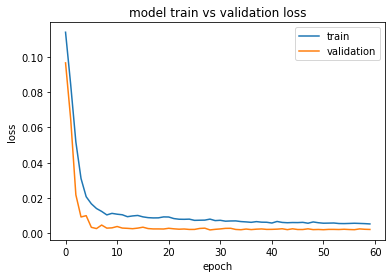

In [ ]:
plot_model(history_covid)

In [ ]:
# predict the test set 
yhat = model_predict(model_covid, n_steps_in, n_features, x_test)

In [ ]:
# MSE
from sklearn.metrics import mean_squared_error 
print(mean_squared_error(y_test,yhat))

0.004972956858730325


In [ ]:
# RMSE
rmse = sqrt(mean_squared_error(y_test, yhat))
print(rmse)

0.11084642218353369


In [ ]:
def plot_results(y_test, yhat):  
  # plot train and validation loss
  pred = np.zeros(len(yhat))
  for x in range(0, len(yhat)):
    pred[x] = ((1/n_steps_out)*sum((np.abs((yhat[x,:])))))
  pyplot.plot(pred[:])
  pyplot.plot(Target[int(len(Target)-len(yhat)):])
  pyplot.title('Actual vs Prediction')
  pyplot.ylabel('DailyTotals')
  pyplot.xlabel('Day')
  pyplot.legend(['Pred', 'Act'], loc='upper right')

  pyplot.show()


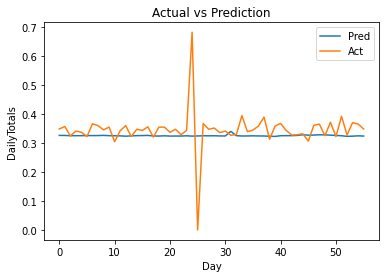

In [ ]:
# plot the prediction versus actual 
plot_results(y_test, yhat)

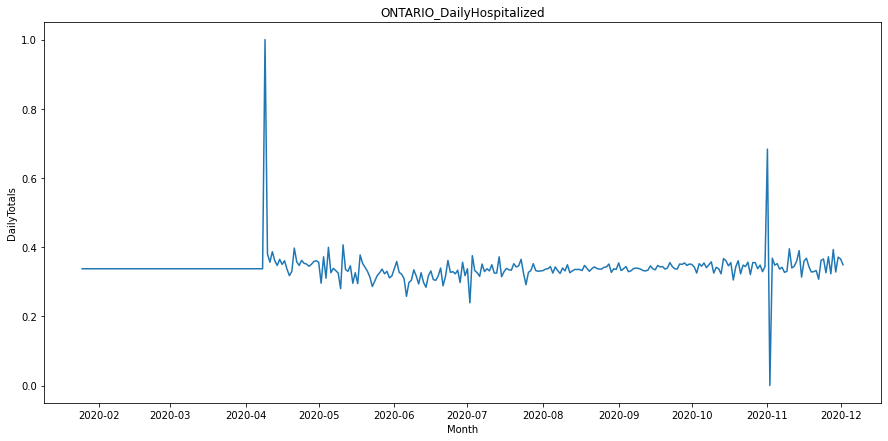

In [ ]:
df = data_new['ONTARIO_DailyHospitalized']
pyplot.figure(figsize=(15,7))
pyplot.plot(df[:])
pyplot.title('ONTARIO_DailyHospitalized')
pyplot.ylabel('DailyTotals')
pyplot.xlabel('Month')

pyplot.show()

In [ ]:
# MAPE
def mape_error(y_test, yhat):
  mape = np.zeros(len(yhat))
  for x in range(0, len(yhat)):
    mape[x] = ((1/n_steps_out)*sum((np.abs((y_test[x,:] - yhat[x,:])/y_test[x,:]))))*100
  print("Min MAPE %:")
  print(min(mape))
  print("Mean MAPE %:")
  print(sum(mape)/len(y_test))
  print("Median MAPE %:")
  print(statistics.median(mape))
  print("Max MAPE %:")
  print(max(mape))
  return mape


In [ ]:
mape = mape_error(y_test, yhat)

Min MAPE %:
3.9543106247216233
Mean MAPE %:
inf
Median MAPE %:
6.1621972437598895
Max MAPE %:
inf


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


### Multi step CNN 

In [ ]:
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [ ]:
def build_model_CNN(units_cnn, n_steps_in, n_steps_out, n_features, ep, x_train, y_train, x_val, y_val, shuff):

  model = Sequential()
  model.add(Conv1D(filters=units_cnn, kernel_size=2, activation='relu', input_shape=(n_steps_in, n_features)))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(50, activation='relu'))
  model.add(Dense(n_steps_out))
  model.compile(optimizer='adam', loss='mse')

  # Fitting the RNN to the Training set
  history = model.fit(x_train, y_train, epochs=ep, validation_data=(x_val, y_val), shuffle=shuff, verbose=0)
  return model, history

In [ ]:
def model_predict_CNN(model, n_steps_in, n_features, x_test):
  yhat = np.zeros((len(x_test),7))
  #print(y_test.shape)
  for x in range(0,len(x_test)):
    x_input = x_test[x,:,:]
    yhat[x,:] = model.predict(x_input.reshape((1, n_steps_in, n_features)), verbose=0)
  return yhat

In [ ]:
[model_CNN, history_CNN] = build_model_CNN (64, n_steps_in, n_steps_out, n_features, 60, x_train, y_train, x_val, y_val, shuff= False)

In [ ]:
yhat = model_predict(model_CNN, n_steps_in, n_features, x_test)

In [ ]:
mape = mape_error(y_test, yhat)

Min MAPE %:
1.8158567772255922
Mean MAPE %:
inf
Median MAPE %:
5.7891869089073555
Max MAPE %:
inf


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


In [ ]:
# MSE
print(mean_squared_error(y_test,yhat))

0.0046113645081409865


### ARIMA model

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [ ]:
df = data_new[['ONTARIO_DailyHospitalized']]

In [ ]:
# MAPE
def mape_arima(y_test, yhat):
  mape = np.zeros(len(yhat))
  for x in range(0, len(yhat)):
    mape[x] = (sum((np.abs((y_test[x] - yhat[x])/y_test[x]))))*100

  print("Min MAPE %:")
  print(min(mape))
  print("Mean MAPE %:")
  print(sum(mape)/len(y_test))
  print("Median MAPE %:")
  print(statistics.median(mape))
  print("Max MAPE %:")
  print(max(mape))
  return mape

In [ ]:

train_data, test_data = df[0:int(len(df)*0.80)], df[int(len(df)*0.80):]
training_data = train_data['ONTARIO_DailyHospitalized'].values
test_data = test_data['ONTARIO_DailyHospitalized'].values

history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(4,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)

# MSE_error = mean_squared_error(test_data, model_predictions)
# error_ARIMA_df = pd.DataFrame(data = MSE_error)
# MAPE_arima = mape_arima(test_data, model_predictions)
# MED_MAPE_ARIMA_df = pd.DataFrame(statistics.median(MAPE_arima))
  
  # print('Testing Mean Squared Error is {}'.format(MSE_error))

In [ ]:
import numpy as np

MAPE_arima = mape_arima(test_data, model_predictions)
MED_MAPE_ARIMA = np.array([statistics.median(MAPE_arima)])
MED_MAPE_ARIMA_df = pd.DataFrame(MED_MAPE_ARIMA)

MSE_error = mean_squared_error(test_data, model_predictions)
MSE_error = np.array([MSE_error])
error_ARIMA_df = pd.DataFrame(MSE_error)

Min MAPE %:
0.04820402100394462
Mean MAPE %:
inf
Median MAPE %:
4.014368910827957
Max MAPE %:
inf


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


In [ ]:
def plot_arima(y_test, yhat):  
  # plot train and validation loss

  pyplot.plot(yhat[:])
  pyplot.plot(y_test[:])
  pyplot.title('Actual vs Prediction')
  pyplot.ylabel('DailyTotals')
  pyplot.xlabel('Day')
  pyplot.legend(['Pred', 'Act'], loc='upper right')

  pyplot.show()


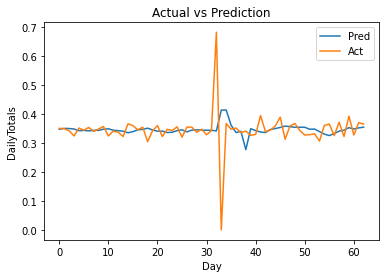

In [ ]:
plot_arima(test_data, model_predictions)

## Sensitivity Analysis

In [ ]:
error_LSTM_sens = [0 for i in range(5)] 
MAPE_LSTM_sens = [0 for i in range(5)] 
 
from sklearn.metrics import mean_squared_error 


[model_covid, history_covid] = build_model(64, n_steps_in, n_steps_out, n_features, 80, x_train, y_train, x_val, y_val, shuff= False)
yhat_LSTM = model_predict(model_covid, n_steps_in, n_features, x_test)
# LSTM MSE
error_LSTM_sens[0] = mean_squared_error(y_test,yhat_LSTM)
# LSTM MED MAPE
MAPE_LSTM_sens[0] = mape_error(y_test, yhat_LSTM)

# change epochs 
[model_covid, history_covid] = build_model(64, n_steps_in, n_steps_out, n_features, 60, x_train, y_train, x_val, y_val, shuff= False)
yhat_LSTM = model_predict(model_covid, n_steps_in, n_features, x_test)
# LSTM MSE
error_LSTM_sens[1] = mean_squared_error(y_test,yhat_LSTM)
# LSTM MED MAPE
MAPE_LSTM_sens[1] = mape_error(y_test, yhat_LSTM)

# change untis 
[model_covid, history_covid] = build_model(50, n_steps_in, n_steps_out, n_features, 80, x_train, y_train, x_val, y_val, shuff= False)
yhat_LSTM = model_predict(model_covid, n_steps_in, n_features, x_test)
# LSTM MSE
error_LSTM_sens[2] = mean_squared_error(y_test,yhat_LSTM)
# LSTM MED MAPE
MAPE_LSTM_sens[2] = mape_error(y_test, yhat_LSTM)

# change layers 
[model_covid, history_covid] = build_model_2layer(64, n_steps_in, n_steps_out, n_features, 80, x_train, y_train, x_val, y_val, shuff= False)
yhat_LSTM = model_predict(model_covid, n_steps_in, n_features, x_test)
# LSTM MSE
error_LSTM_sens[3] = mean_squared_error(y_test,yhat_LSTM)
# LSTM MED MAPE
MAPE_LSTM_sens[3] = mape_error(y_test, yhat_LSTM)


# change layers and epochs 
[model_covid, history_covid] = build_model_2layer(64, n_steps_in, n_steps_out, n_features, 60, x_train, y_train, x_val, y_val, shuff= False)
yhat_LSTM = model_predict(model_covid, n_steps_in, n_features, x_test)
# LSTM MSE
error_LSTM_sens[4] = mean_squared_error(y_test,yhat_LSTM)
# LSTM MED MAPE
MAPE_LSTM_sens[4] = mape_error(y_test, yhat_LSTM)


In [ ]:
error_LSTM_df_sens = pd.DataFrame(error_LSTM)

In [ ]:
MED_MAPE_LSTM_sens = [0 for i in range(5)] 

for i in range(5):
  MED_MAPE_LSTM_sens[i] = (statistics.median(MAPE_LSTM_sens[i]))
MED_MAPE_LSTM_df_sens = pd.DataFrame(MED_MAPE_LSTM_sens)

In [ ]:
LSTM_df_sens = pd.concat([error_LSTM_df_sens, MED_MAPE_LSTM_df_sens], axis=1, sort=False)
LSTM_df_sens.columns = ['LSTM MSE', 'LSTM MAPE']

In [ ]:
LSTM_df_sens.index  = ['1LSTM_64_80', '1LSTM_64_60', '1LSTM_50_80', '2LSTM_64_80', '2LSTM_64_60']
LSTM_df_sens

,LSTM MSE,LSTM MAPE
1LSTM_64_80,0.016533,5.294614
1LSTM_64_60,0.015752,5.257208
1LSTM_50_80,0.019694,6.445727
2LSTM_64_80,0.012031,4.904847
2LSTM_64_60,0.022288,5.303507


## Comparative Analysis 

In [ ]:
error_LSTM = [0 for i in range(5)] 
error_CNN = [0 for i in range(5)] 
MAPE_LSTM = [0 for i in range(5)] 
MAPE_CNN = [0 for i in range(5)] 


from sklearn.metrics import mean_squared_error 


for a in range (5):
  # BUILD AND PREDICT LSTM
  [model_covid, history_covid] = build_model(64, n_steps_in, n_steps_out, n_features, 60, x_train, y_train, x_val, y_val, shuff= False)
  yhat_LSTM = model_predict(model_covid, n_steps_in, n_features, x_test)
  # LSTM MSE
  error_LSTM[a] = mean_squared_error(y_test,yhat_LSTM)
  # LSTM MED MAPE
  MAPE_LSTM[a] = mape_error(y_test, yhat_LSTM)


  #---------------------
  # BUILD AND PREDICT CNN
  [model_CNN, history_CNN] = build_model_CNN (64, n_steps_in, n_steps_out, n_features, 60, x_train, y_train, x_val, y_val, shuff= False)
  yhat_CNN = model_predict(model_CNN, n_steps_in, n_features, x_test)
  # CNN MSE
  error_CNN[a] = mean_squared_error(y_test,yhat_CNN)
  # CNN MED MAPE
  MAPE_CNN[a] = mape_error(y_test, yhat_CNN)





In [ ]:
MED_MAPE_LSTM = [0 for i in range(5)] 
MED_MAPE_CNN = [0 for i in range(5)] 

for i in range(5):
  MED_MAPE_LSTM[i] = (statistics.median(MAPE_LSTM[i]))
  MED_MAPE_CNN[i] = (statistics.median(MAPE_CNN[i]))
print(statistics.mean(error_LSTM))
print(statistics.mean(error_CNN))
print(statistics.mean(MED_MAPE_LSTM))
print(statistics.mean(MED_MAPE_CNN))

0.004904430481779547
0.004646436644808772
5.959950864565091
5.497070774957135


Store in dataframes 

In [ ]:
error_LSTM_df = pd.DataFrame(error_LSTM)
error_CNN_df = pd.DataFrame(error_CNN)
MED_MAPE_LSTM_df = pd.DataFrame(MED_MAPE_LSTM)
MED_MAPE_CNN_df = pd.DataFrame(MED_MAPE_CNN)

In [ ]:

LSTM_df = pd.concat([error_LSTM_df, MED_MAPE_LSTM_df], axis=1, sort=False)
LSTM_df.columns = ['LSTM MSE', 'LSTM MAPE']

CNN_df = pd.concat([error_CNN_df, MED_MAPE_CNN_df], axis=1, sort=False)
CNN_df.columns = ['CNN MSE', 'CNN MAPE']

ARIMA_df = pd.concat([error_ARIMA_df, MED_MAPE_ARIMA_df], axis=1, sort=False)
ARIMA_df.columns = ['ARIMA MSE', 'ARIMA MAPE']

In [ ]:
pd.set_option("display.max_columns", 10)
comparative_analysis = pd.concat([LSTM_df, CNN_df, ARIMA_df],  axis=1, sort=False)
comparative_analysis = comparative_analysis.fillna('')
comparative_analysis

,LSTM MSE,LSTM MAPE,CNN MSE,CNN MAPE,ARIMA MSE,ARIMA MAPE
0,0.004851,5.816786,0.004608,5.083082,0.00506769,4.01437
1,0.005017,6.490232,0.004645,5.807036,,
2,0.004751,5.257930,0.004628,5.555339,,
3,0.004876,5.757525,0.004644,5.783344,,
4,0.005027,6.477281,0.004707,5.256553,,
